In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import os

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((300,225)),
        transforms.ToTensor(),
       # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop((300,225)),
        transforms.ToTensor(),
    ]),
}

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((300,225)),
        #transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
       # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((300,225)),
        #transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
    ]),
}

PARAMETERS:

In [20]:
lr = 0.001
mm = 0.5
batch_size = 16

In [31]:
data_dir = './new_data_balanced'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

In [32]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 8415, 'test': 671}


['benign', 'malignant']

In [33]:
model = models.resnet50(weights=none)
""" model = models.vgg16(pretrained=True) """

for name, param in model.named_parameters():#reactiviting shit or smtg i dont get it, look into this later
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = True
        
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm) 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

NameError: name 'none' is not defined

In [ ]:

num_epochs = 10
for epoch in range(1,num_epochs+1):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'\nepoch: {epoch} \n{phase} Loss: {epoch_loss:.4f} Acc: {100*(epoch_acc):.4f}%')


epoch: 1 
train Loss: 0.0472 Acc: 98.4314%

epoch: 1 
test Loss: 0.5106 Acc: 84.3517%


In [20]:
# Save the model
torch.save(model.state_dict(), 'model_85-17.pth')

EVAL FRESHLY TRAINED MODEL:

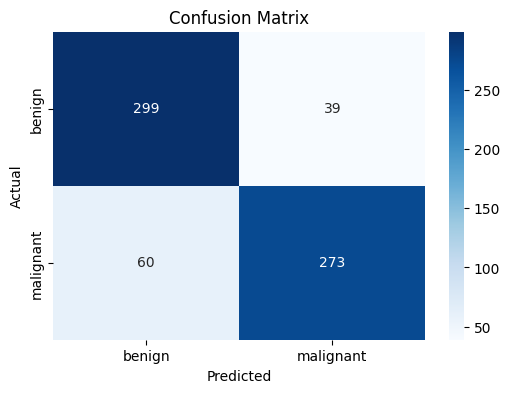

In [30]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming new_model is your trained model
# Assuming you have a DataLoader named 'test_loader' for your test dataset

# Set model to evaluation mode
model.eval()

# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in dataloaders['test']:  # Assuming you have a test DataLoader
        inputs = inputs.to(device)  # Move inputs to device (GPU/CPU)
        labels = labels.to(device)  # Move labels to device (GPU/CPU)

        # Get model predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get predicted class (0 or 1 for 2-class classification)

        # Store predictions and actual labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


EVAL LOADED MODEL:

1.)Loading the model(.pth file):

In [14]:
model_load = models.resnet50(pretrained=False)  
model_load.fc = nn.Linear(model_load.fc.in_features, 1000)  

model_load.load_state_dict(torch.load('Model_89-3.pth'))
model_load.eval()

new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2) 
pretrained_dict = model_load.state_dict()

new_model_dict = new_model.state_dict()

pretrained_dict = {k: v for k, v in pretrained_dict.items() if "fc" not in k}


new_model_dict.update(pretrained_dict)
new_model.load_state_dict(new_model_dict)

c:\Users\Agastya\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Agastya\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Agastya\AppData\Local\Temp\ipykernel_18492\15682262.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a fut

<All keys matched successfully>

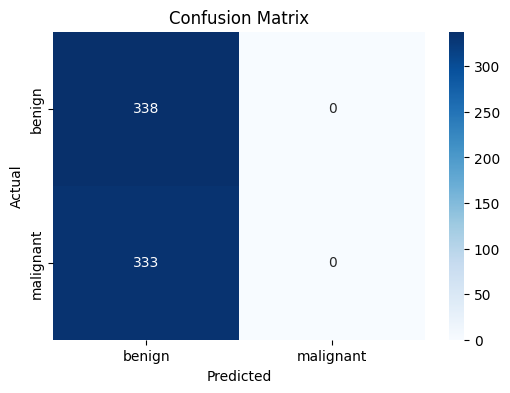

In [32]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = "cpu"
model_load.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)  
        labels = labels.to(device) 

        outputs = model_load(inputs)
        _, preds = torch.max(outputs, 1) 

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
